In [2]:
%%capture
!pip install fastai==1.0.61

In [29]:
??s_learner.get_preds

Signature:
s_learner.get_preds(
    ds_type:fastai.basic_data.DatasetType=<DatasetType.Valid: 2>,
    activ:torch.nn.modules.module.Module=None,
    with_loss:bool=False,
    n_batch:Union[int, NoneType]=None,
    pbar:Union[fastprogress.fastprogress.ProgressBar, NoneType]=None,
) -> List[torch.Tensor]
Source:   
    def get_preds(self, ds_type:DatasetType=DatasetType.Valid, activ:nn.Module=None,
                  with_loss:bool=False, n_batch:Optional[int]=None, pbar:Optional[PBar]=None) -> List[Tensor]:
        "Return predictions and targets on `ds_type` dataset."
        lf = self.loss_func if with_loss else None
        activ = ifnone(activ, _loss_func2activ(self.loss_func))
        if not getattr(self, 'opt', False): self.create_opt(defaults.lr, self.wd)
        callbacks = [cb(self) for cb in self.callback_fns + listify(defaults.extra_callback_fns)] + listify(self.callbacks)
        return get_preds(self.model, self.dl(ds_type), cb_handler=CallbackHandler(callbacks),
           

## Class for knowledge distillation

In [3]:
from fastai.basics import *

class KnowledgeDistillation(LearnerCallback):
    def __init__(self, learn:Learner, teacher:Learner, T:float=20., α:float=0.7):
        super().__init__(learn)
        self.teacher = teacher
        self.T, self.α = T, α
    
    def on_backward_begin(self, last_input, last_output, last_target, **kwargs):
        self.teacher.model.eval()
        teacher_output = self.teacher.model(last_input)
        new_loss = DistillationLoss(last_output, last_target, teacher_output, self.T, self.α)
        
        return {'last_loss': new_loss}

def DistillationLoss(y, labels, teacher_scores, T, alpha):
    return nn.KLDivLoss(reduction='batchmean')(F.log_softmax(y/T, dim=-1), F.softmax(teacher_scores/T, dim=-1)) * (T*T * 2.0 * alpha) + F.cross_entropy(y, labels) * (1. - alpha)

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Setting workspace

In [4]:
import boto3
import os
import numpy as np
from pathlib import Path
from argparse import Namespace
from fastai.vision import *

args = Namespace(
    root = "/".join(os.getcwd().split("/")[:-1]),
    bucket_name = "sagemaker-us-west-2-430127992102",
    key = "ClassificationModel",
    image_dir = "fastai_data",
    data_dir = "dataset",
    tar_file_name = "dataset.tar.gz",
    model_dir = "model",
    tar_model_name = "model.tar.gz"
)
s3 = boto3.resource('s3')

In [5]:
model_path = os.path.join(args.root, args.model_dir)
data_path = Path(os.path.join(args.root, args.data_dir))
labels = os.listdir(data_path)

## Loading data

In [6]:
data = ImageDataBunch.from_folder(data_path, valid_pct=0.2, bs=32, ds_tfms=get_transforms(), size=240, num_workers=4).normalize(imagenet_stats)

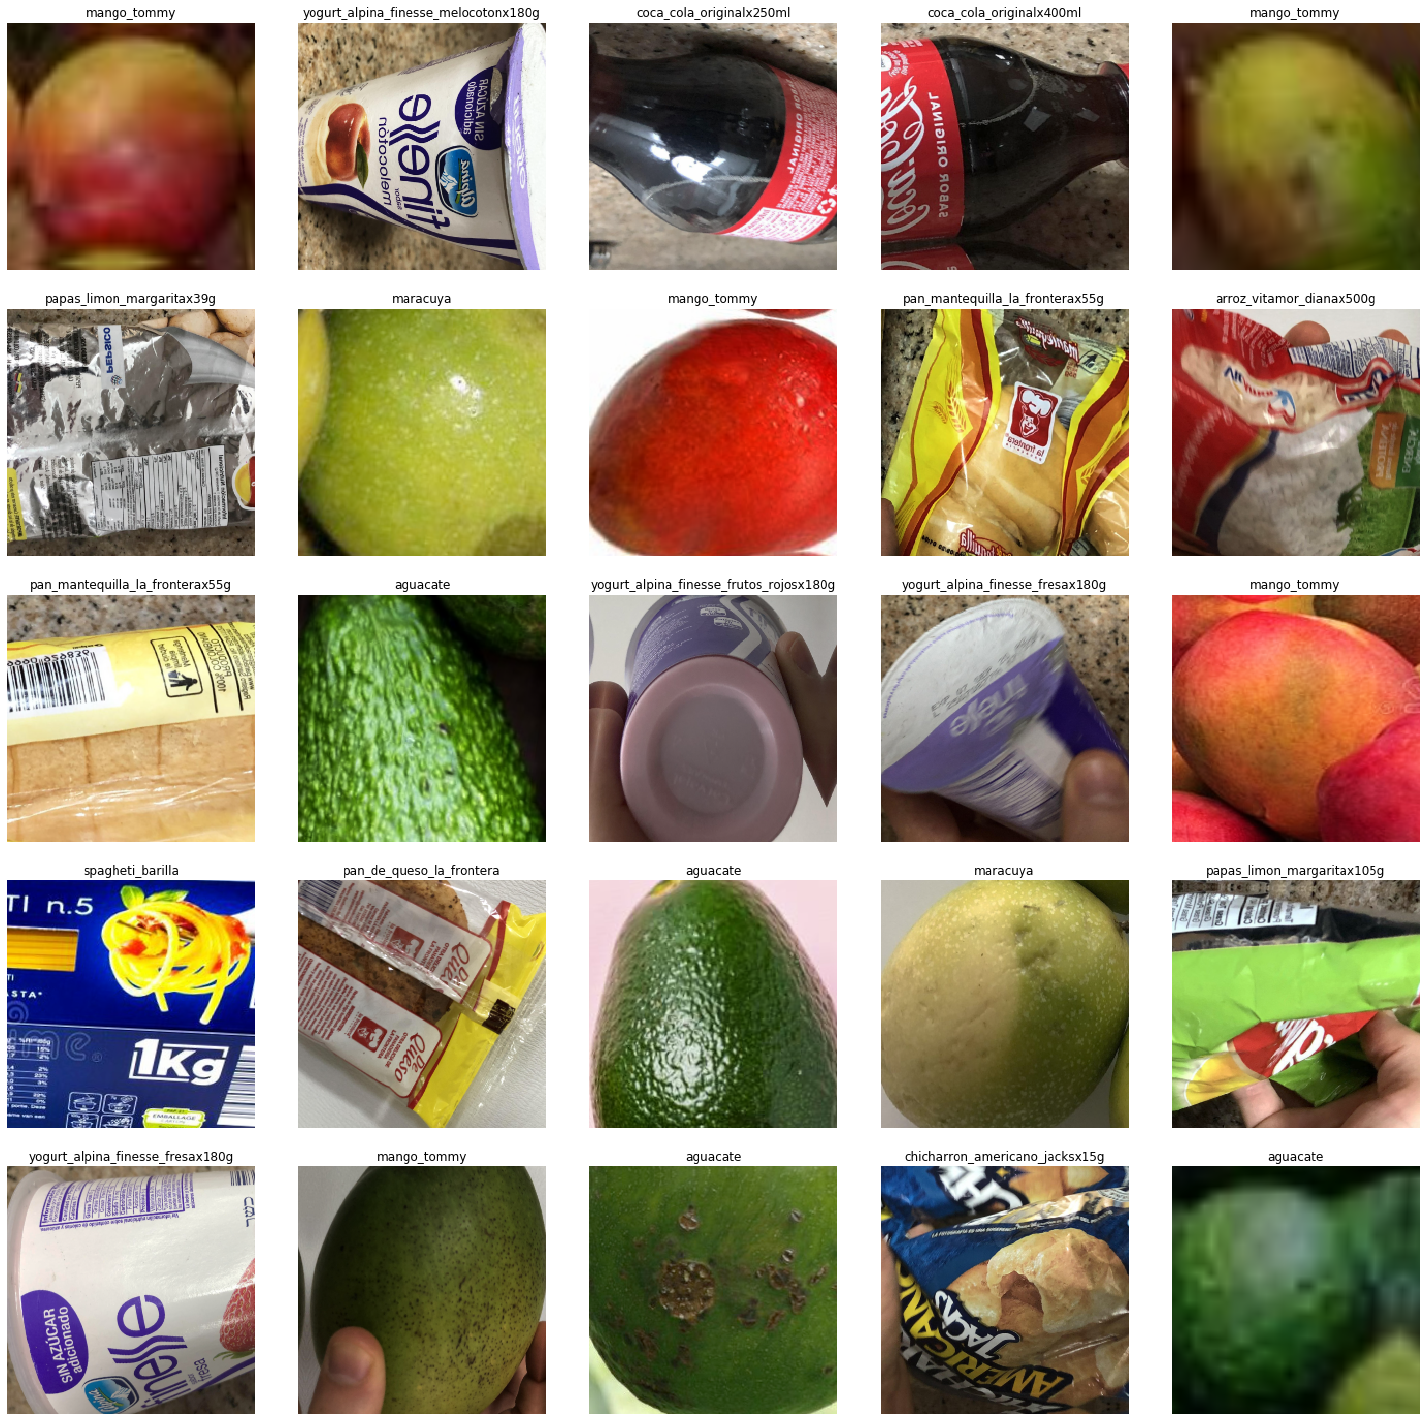

In [32]:
data.show_batch()

## Training pretrained model

In [25]:
t_learner = cnn_learner(data, models.resnet34, metrics=[error_rate,accuracy])

In [35]:
t_learner.lr_find()
t_learner.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [36]:
t_learner.fit_one_cycle(3,1e-2)

In [37]:
t_learner.save(os.path.join(model_path,'teacher_stage-1'))

In [11]:
t_learner.load(os.path.join(model_path,'teacher_stage-1'))

Learner(data=ImageDataBunch;

Train: LabelList (4053 items)
x: ImageList
Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240)
y: CategoryList
arroz_vitamor_dianax500g,arroz_vitamor_dianax500g,arroz_vitamor_dianax500g,arroz_vitamor_dianax500g,arroz_vitamor_dianax500g
Path: /home/ec2-user/SageMaker/classification_model/dataset;

Valid: LabelList (1013 items)
x: ImageList
Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240)
y: CategoryList
papas_limon_margaritax39g,aguacate,yogurt_alpina_finesse_fresax150g,maracuya,mango_tommy
Path: /home/ec2-user/SageMaker/classification_model/dataset;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilatio

In [10]:
t_learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


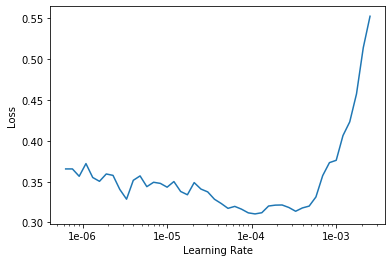

In [11]:
t_learner.lr_find()
t_learner.recorder.plot()

In [ ]:
t_learner.fit_one_cycle(100,6e-5)

In [26]:
t_learner.load(os.path.join(model_path,'teacher_stage-2'))

Learner(data=ImageDataBunch;

Train: LabelList (4053 items)
x: ImageList
Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240)
y: CategoryList
arroz_vitamor_dianax500g,arroz_vitamor_dianax500g,arroz_vitamor_dianax500g,arroz_vitamor_dianax500g,arroz_vitamor_dianax500g
Path: /home/ec2-user/SageMaker/classification_model/dataset;

Valid: LabelList (1013 items)
x: ImageList
Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240)
y: CategoryList
arroz_blanco_carullax1000g,aguacate,mango_tommy,mango_tommy,mango_tommy
Path: /home/ec2-user/SageMaker/classification_model/dataset;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=Fa

In [9]:
s_learner = cnn_learner(data, models.resnet18, metrics=[error_rate,accuracy])

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.0020892962347716093)

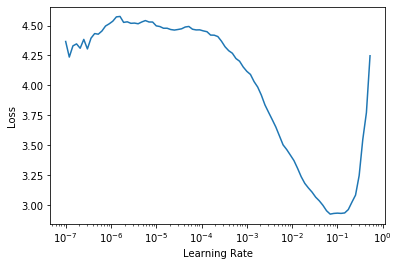

In [10]:
s_learn.lr_find()

In [ ]:
s_learner.fit_one_cycle(4, 1e-2, callbacks=[KnowledgeDistillation(s_learner, teacher=t_learner)])

In [28]:
s_learner.load(os.path.join(model_path, 'student-stage-1'))

Learner(data=ImageDataBunch;

Train: LabelList (4053 items)
x: ImageList
Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240)
y: CategoryList
arroz_vitamor_dianax500g,arroz_vitamor_dianax500g,arroz_vitamor_dianax500g,arroz_vitamor_dianax500g,arroz_vitamor_dianax500g
Path: /home/ec2-user/SageMaker/classification_model/dataset;

Valid: LabelList (1013 items)
x: ImageList
Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240)
y: CategoryList
arroz_blanco_carullax1000g,aguacate,mango_tommy,mango_tommy,mango_tommy
Path: /home/ec2-user/SageMaker/classification_model/dataset;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=Fa

In [29]:
s_learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


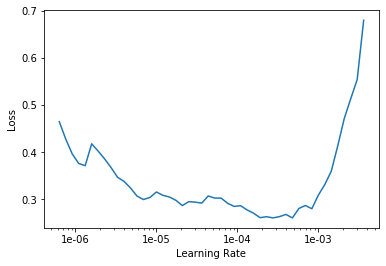

In [30]:
s_learner.lr_find()
s_learner.recorder.plot()

In [ ]:
s_learner.fit_one_cycle(100, 7e-6, callbacks=[KnowledgeDistillation(s_learner, teacher=t_learner)])

In [10]:
s_learner.load(os.path.join(model_path, 'student-stage-2'))

Learner(data=ImageDataBunch;

Train: LabelList (4053 items)
x: ImageList
Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240)
y: CategoryList
arroz_vitamor_dianax500g,arroz_vitamor_dianax500g,arroz_vitamor_dianax500g,arroz_vitamor_dianax500g,arroz_vitamor_dianax500g
Path: /home/ec2-user/SageMaker/classification_model/dataset;

Valid: LabelList (1013 items)
x: ImageList
Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240)
y: CategoryList
pan_de_queso_la_frontera,mango_tommy,maracuya,aguacate,mango_tommy
Path: /home/ec2-user/SageMaker/classification_model/dataset;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)


In [13]:
s_learner.export(os.path.join(model_path,'student_2.pkl'))

In [7]:
s_learner = load_learner(model_path,'student_2.pkl')

## Prediction

aguacate 0.9999428987503052
{
   "probabilities": {
      "aguacate": 0.9999428987503052,
      "arroz_basmati_castellanox1000g": 3.954210967549443e-07,
      "arroz_blanco_carullax1000g": 3.511993895699561e-07,
      "arroz_vitamor_dianax500g": 1.2375684832477418e-07,
      "chicharron_americano_jacksx15g": 2.2206542382718908e-08,
      "coca_cola_originalx250ml": 4.197686394036282e-07,
      "coca_cola_originalx400ml": 5.495336381500238e-07,
      "mango_tommy": 1.4944007489248179e-05,
      "maracuya": 3.5868026316165924e-05,
      "pan_de_queso_la_frontera": 8.261754658178688e-08,
      "pan_mantequilla_la_fronterax55g": 5.941234171302767e-09,
      "papas_limon_margarita_packeconomicox300g": 2.0481842000208417e-07,
      "papas_limon_margaritax105g": 1.0816604856245249e-07,
      "papas_limon_margaritax110g": 1.62652111157513e-06,
      "papas_limon_margaritax39g": 6.73802389883349e-07,
      "spagheti_barilla": 5.455837595036428e-07,
      "yogurt_alpina_finesse_fresax150g": 1.48

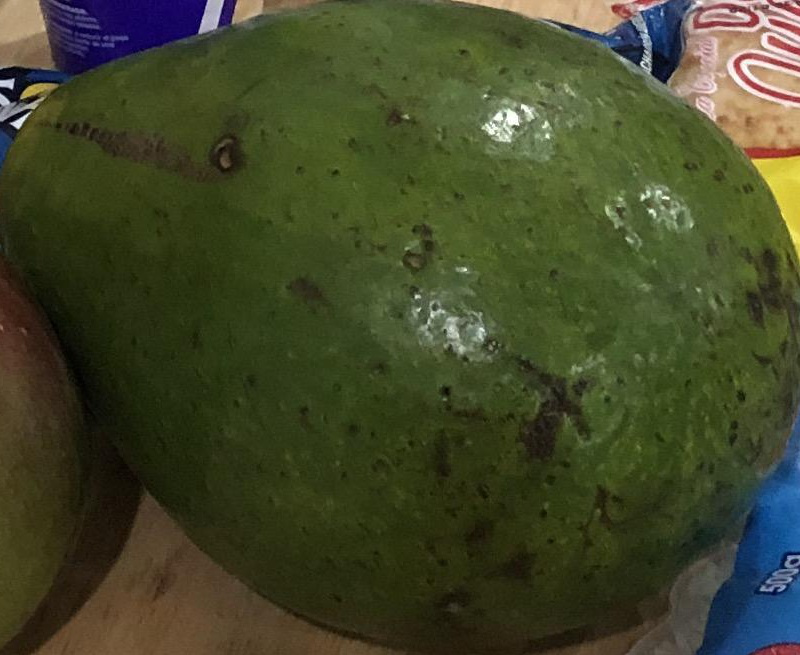

In [23]:
import json
from PIL import Image
#!curl "https://www.merkadomi.com/wp-content/uploads/2018/07/COCA-COLA-ORIGINAL-400ML.jpg" --output test.jpg
img_path = 'test1.jpg'
img = open_image(img_path)
pred_class,pred_idx,outputs = s_learner.predict(img)
print(pred_class, outputs[pred_idx].item())
print(json.dumps({"probabilities": {class_name: prob.item() 
                         for class_name, prob in zip(s_learner.data.classes, outputs)}}, indent=3))

#!rm test.jpg
img

In [22]:
?? s_learner.model

Signature:       s_learner.model(*input, **kwargs)
Type:           Sequential
String form:   
Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   

In [23]:
def make_tarfile(output_filename, source_dir):
    with tarfile.open(output_filename, "w:gz") as tar:
        tar.add(source_dir, arcname=os.path.basename(source_dir))
    return output_filename

In [24]:
args.output_filename = make_tarfile(os.path.join(args.root, args.model_dir, args.tar_model_name), 
                                             os.path.join(args.root, args.model_dir))
s3.meta.client.upload_file(args.output_filename, Bucket=args.bucket_name, Key=os.path.join(args.key,
                                                                                         args.model_dir,
                                                                                         args.tar_model_name))
os.remove(args.output_filename)

In [26]:
batch = s_learner.data.one_batch()
batch

StopIteration: 